In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
sys.path.append('..')

import utilities.functions as functions
import utilities.descritiva as descritiva

from utilities.descritiva import  (
    matriz_migracao,
    cria_base_decil_wide
)

from utilities.functions import (
    summary,
    gerar_resumo_decis,
    resumo_coorte_ativa,
    process_orders_pandas

)
from pathlib import Path
BASE_PATH = Path("/Users/maceli/ifood_cs/dados") 


In [2]:
df = pd.read_parquet(BASE_PATH / "silver" / "df_p_2.parquet")
df

,customer_id,is_target,active,created_at,delivery_address_state,merchant_id,order_created_at,order_id,order_total_amount,origin_platform
0,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,4d12c9e2cf2720b3e638c060eed65a35b5cc1e3b7eaf66...,2019-01-29T19:44:19.000Z,31eb01fc4bc7c297a403f662e55cf9e59dc1e9f4dc551f...,11.49,IOS
1,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,aeb2c47a6a45243ba227c4fcc2b073c2da30b0637ba136...,2019-01-20T14:05:52.000Z,7201c79e26943fe0ef09e3d15240eb90f6b4e8c9bba2f6...,22.90,IOS
2,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,fe61b80037e191b6b79523c9c4e69b2a73c50bda954fd7...,2019-01-10T23:49:30.000Z,c9c7729d1fafde77f4139389972fb715ebe3f05bb1ec79...,68.30,IOS
3,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,95bbceba7b5cd56a8442a6d4d4edb760d310608440d9e2...,2019-01-17T22:28:57.000Z,721195cbf745297a40ef05fcd85265054a2415c70fe41d...,61.00,IOS
4,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,4d12c9e2cf2720b3e638c060eed65a35b5cc1e3b7eaf66...,2019-01-18T18:41:24.000Z,0fe14d829a5bbc40e3ea93ab13da7e18d81945e9c480fb...,14.99,IOS
...,...,...,...,...,...,...,...,...,...,...
453219,e42d74ffaa7adef9882316920889646fdab86d29a9427a...,control,True,2018-04-05T16:58:48.527Z,SP,647df078aee20098ae1cb8373917bbfd8282f4c29699fd...,2019-01-10T15:37:04.000Z,6688eafb2572ad16e9b9cfb2839437a2a6bf026b1f911d...,26.90,ANDROID
453220,de1835dd1e6dd25dbebd2a473a48e4771dcc74001674fd...,control,True,2018-04-06T00:48:34.058Z,MG,68ef7d3144921c0c2ca680834c8dc28b28f41a18e889bb...,2019-01-17T22:41:25.000Z,2a0a052a30d60f2f19257574a8567854c0cbf8d3c4b120...,31.80,ANDROID
453221,b0c1a3d52ab1e460cc2f76acf2b233007538c56de0b672...,target,True,2018-03-24T02:35:03.256Z,AM,e14bce2f4b002d2af2f9f51ebdf5d35e070bcbeb273c91...,2019-01-07T00:17:39.000Z,94ef4399ccfb868967ae898cfcf816333a2201808b4245...,47.00,IOS
453222,a80e55daed49d908c1eeb881abb62fa1bba4bf682dba6a...,target,True,2018-04-05T21:03:24.346Z,MG,200b0358a358c6475753a03c3feacd4acb303e7d33ba13...,2019-01-09T23:18:19.000Z,ba76a44b231a242bbad8e81167bc8c5dac01e9621c7b36...,56.90,IOS


In [3]:
df["order_created_at"] = pd.to_datetime(df["order_created_at"], utc=True)
df['unique_order_hash'] = pd.util.hash_pandas_object(
        df[['customer_id', 'order_created_at','order_id']],
        index=False
    )
df = df.drop(columns=['order_id'], errors='ignore')
df["order_created_month"] = df["order_created_at"].dt.month
id_both_monht=df[df['order_created_month']==12]['customer_id'].unique()
df = df[df['customer_id'].isin(id_both_monht)].reset_index(drop=True)
df["day_month_year"] = df["order_created_at"].dt.strftime("%d-%m-%Y")
df["weekday"] = df["order_created_at"].dt.day_name()
df["hour"] = df["order_created_at"].dt.hour

df["day"] = df["order_created_at"].dt.day

In [4]:
df_stats_mes = df.groupby(['order_created_month', 'is_target'])['order_total_amount'].agg(
    Média=('mean'),
    Mediana=('median'),
    Mínimo=('min'),
    Máximo=('max'),
    Desvio_Padrão=('std')
).round(2)
df_stats_mes

Média  Mediana  Mínimo  Máximo  Desvio_Padrão
order_created_month is_target                                               
1                   control    47.80     39.9     2.5  1129.7          34.19
                    target     48.09     39.9     0.0  2955.9          35.53
12                  control    47.57     39.6     2.5  1129.7          34.40
                    target     47.69     39.9     0.0  2955.9          35.56

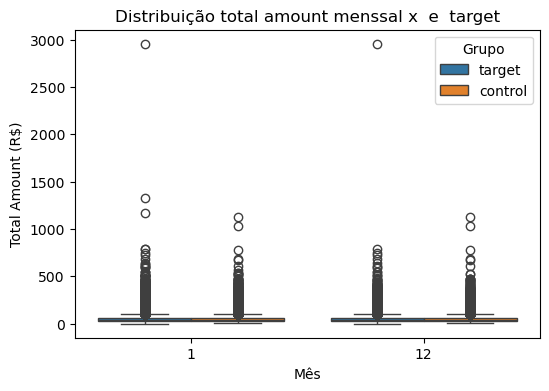

In [5]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    y='order_total_amount',
    x='order_created_month',  
    hue='is_target'          
)
plt.title('Distribuição total amount menssal x  e  target')
plt.ylabel('Total Amount (R$)')
plt.xlabel('Mês')
plt.legend(title='Grupo')
plt.show()

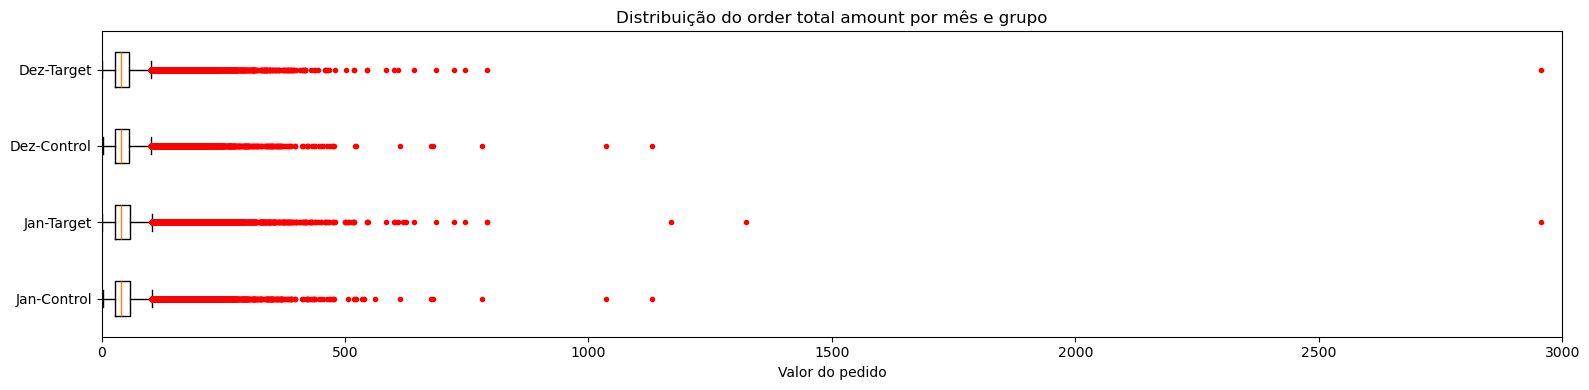

In [6]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')

jan_control = df[
    (df['order_created_month'] == 1) &
    (df['is_target'] == 'control')
]['order_total_amount']

jan_target = df[
    (df['order_created_month'] == 1) &
    (df['is_target'] == 'target')
]['order_total_amount']

dez_control = df[
    (df['order_created_month'] == 12) &
    (df['is_target'] == 'control')
]['order_total_amount']

dez_target = df[
    (df['order_created_month'] == 12) &
    (df['is_target'] == 'target')
]['order_total_amount']

plt.figure(figsize=(16, 4))

plt.boxplot(
    [jan_control, jan_target, dez_control, dez_target],
    vert=False,
    flierprops=red_square
)

plt.yticks(
    [1, 2, 3, 4],
    ['Jan-Control', 'Jan-Target', 'Dez-Control', 'Dez-Target']
)

plt.xlim(0, 3000)
plt.title('Distribuição do order total amount por mês e grupo')
plt.xlabel('Valor do pedido')
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
from scipy.stats import zscore

def mark_outliers_iqr_zscore_mad(df, mad_threshold=3.5):
    df = df.copy()

    # Flags
    df['invalid_value'] = False
    df['outlier_iqr'] = False
    df['outlier_zscore'] = False
    df['outlier_mad'] = False

    # Valores auxiliares
    df['lim_inf_iqr'] = np.nan
    df['lim_sup_iqr'] = np.nan
    df['zscore'] = np.nan
    df['mad_score'] = np.nan

    # Regra de negócio: valor deve ser > 0
    df.loc[df['order_total_amount'] <= 0, 'invalid_value'] = True

    df_valid = df[df['order_total_amount'] > 0]

    for mes in sorted(df_valid['order_created_month'].unique()):
        for grupo in df_valid['is_target'].unique():

            mask = (
                (df['order_created_month'] == mes) &
                (df['is_target'] == grupo) &
                (df['order_total_amount'] > 0)
            )

            data = df.loc[mask, 'order_total_amount']

            if len(data) < 5:
                continue

            # =====================
            # IQR
            # =====================
            p75 = np.nanpercentile(data, 75)
            p25 = np.nanpercentile(data, 25)
            iqr = p75 - p25

            lim_sup = p75 + 1.5 * iqr
            lim_inf = p25 - 1.5 * iqr
            lim_inf = max(lim_inf, 0.01)  # não permitir negativo

            df.loc[mask, 'lim_inf_iqr'] = lim_inf
            df.loc[mask, 'lim_sup_iqr'] = lim_sup

            df.loc[
                mask & (
                    (df['order_total_amount'] < lim_inf) |
                    (df['order_total_amount'] > lim_sup)
                ),
                'outlier_iqr'
            ] = True

            # =====================
            # Z-SCORE
            # =====================
            z_vals = zscore(data)
            df.loc[mask, 'zscore'] = z_vals

            df.loc[
                mask & (np.abs(df['zscore']) > 3),
                'outlier_zscore'
            ] = True

            # =====================
            # MAD (Median Absolute Deviation)
            # =====================
            median = np.median(data)
            mad = np.median(np.abs(data - median))

            # evita divisão por zero
            if mad == 0:
                continue

            mad_score = 0.6745 * (data - median) / mad
            df.loc[mask, 'mad_score'] = mad_score

            df.loc[
                mask & (np.abs(df['mad_score']) > mad_threshold),
                'outlier_mad'
            ] = True

    return df


In [8]:
df = mark_outliers_iqr_zscore_mad(df)


In [9]:
df.head()

,customer_id,is_target,active,created_at,delivery_address_state,merchant_id,order_created_at,order_total_amount,origin_platform,unique_order_hash,...,hour,day,invalid_value,outlier_iqr,outlier_zscore,outlier_mad,lim_inf_iqr,lim_sup_iqr,zscore,mad_score
0,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,4d12c9e2cf2720b3e638c060eed65a35b5cc1e3b7eaf66...,2019-01-29 19:44:19+00:00,11.49,IOS,4109894032133637275,...,19,29,False,False,False,False,0.01,104.0,-1.030321,-1.303574
1,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,aeb2c47a6a45243ba227c4fcc2b073c2da30b0637ba136...,2019-01-20 14:05:52+00:00,22.90,IOS,2905704566887177056,...,14,20,False,False,False,False,0.01,104.0,-0.709167,-0.780034
2,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,fe61b80037e191b6b79523c9c4e69b2a73c50bda954fd7...,2019-01-10 23:49:30+00:00,68.30,IOS,11668799743808321253,...,23,10,False,False,False,False,0.01,104.0,0.568692,1.303116
3,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,95bbceba7b5cd56a8442a6d4d4edb760d310608440d9e2...,2019-01-17 22:28:57+00:00,61.00,IOS,8795587544976149387,...,22,17,False,False,False,False,0.01,104.0,0.363221,0.968160
4,2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8...,target,True,2018-01-07T23:37:48.252Z,ES,4d12c9e2cf2720b3e638c060eed65a35b5cc1e3b7eaf66...,2019-01-18 18:41:24+00:00,14.99,IOS,14625526152922815451,...,18,18,False,False,False,False,0.01,104.0,-0.931807,-1.142979


In [10]:
total_amount = df.groupby(['order_created_month','outlier_iqr','outlier_zscore','outlier_mad']).agg(
    total_pedidos=('unique_order_hash', 'nunique')
).round(2)
total_amount

total_pedidos
order_created_month outlier_iqr outlier_zscore outlier_mad               
1                   False       False          False               240302
                    True        False          False                 4148
                                               True                  6117
                                True           True                  4327
12                  False       False          False               143563
                    True        False          False                 2605
                                               True                  3733
                                True           True                  2552

In [ ]:
matriz_migracao_n(df,mes_0=12,mes_1=1,group_by_extra='outlier_mad')


,mes_12,mes_1,is_target,outlier_mad,total_clientes
0,0,1,control,False,249
1,0,1,control,True,641
2,0,1,target,False,322
3,0,1,target,True,1019
4,1,0,control,True,79
5,1,0,target,True,30
6,1,1,control,False,29197
7,1,1,control,True,1843
8,1,1,target,False,37777
9,1,1,target,True,2580


In [ ]:
/Users/maceli/ifood_cs/code/notebook/05.cli_res copy.ipynb

1689

In [13]:
id_p99=acima_p99['customer_id'].unique()

In [ ]:
df['id_p99'] = df['customer_id'].isin(id_p99).astype(int)
df[df['id_p99']==1][['customer_id','unique_order_hash','order_created_month','order_total_amount','day','outlier_iqr','outlier_zscore','outlier_mad','id_p99']].head(10)

,customer_id,unique_order_hash,order_created_month,order_total_amount,day,outlier_iqr,outlier_zscore,outlier_mad,id_p99
6,df4a3b2f7c0e259adb8e71e094405637810013013f4971...,6280395930853013257,1,47.00,26,False,False,False,1
7,df4a3b2f7c0e259adb8e71e094405637810013013f4971...,8375403443903045600,1,81.70,23,False,False,False,1
8,df4a3b2f7c0e259adb8e71e094405637810013013f4971...,4965369037086780196,1,69.40,22,False,False,False,1
9,df4a3b2f7c0e259adb8e71e094405637810013013f4971...,13526963463313600868,1,112.50,25,True,False,False,1
10,df4a3b2f7c0e259adb8e71e094405637810013013f4971...,7409692391608107439,1,195.00,28,True,True,True,1
11,df4a3b2f7c0e259adb8e71e094405637810013013f4971...,12290574871276594958,1,168.00,5,True,True,True,1
12,df4a3b2f7c0e259adb8e71e094405637810013013f4971...,9828447071624588389,1,44.72,22,False,False,False,1
13,df4a3b2f7c0e259adb8e71e094405637810013013f4971...,5766135708987893934,12,168.00,6,True,True,True,1
14,df4a3b2f7c0e259adb8e71e094405637810013013f4971...,16693794814942610970,12,44.72,23,False,False,False,1
454,d384cdf71371c42edbcef807d4d829784f291895fd4b7e...,9598867299421743029,1,49.65,16,False,False,False,1


In [15]:
stats_p99_por_cliente = (
    df[df['id_p99'] == 1]
    .groupby(['customer_id','order_created_month','is_target'])['order_total_amount']
    .agg(
        total_transacoes='count',
        minimo='min',
        maximo='max',
        media='mean'
    )
    .reset_index()   # ISSO resolve seu problema
    .sort_values(by=['customer_id','total_transacoes'], ascending=[False,False])
)

stats_p99_por_cliente.head(10)




,customer_id,order_created_month,is_target,total_transacoes,minimo,maximo,media
3376,ffd67e3530defd1575fe7708561e1c9f7207515d5c615f...,1,control,24,55.60,612.00,178.410417
3377,ffd67e3530defd1575fe7708561e1c9f7207515d5c615f...,12,control,24,55.60,612.00,178.410417
3374,ff5814457402e818468ea6c88349540ef31c55a44c8043...,1,target,1,458.60,458.60,458.600000
3375,ff5814457402e818468ea6c88349540ef31c55a44c8043...,12,target,1,458.60,458.60,458.600000
3372,ff4cf895b5d0dfd70fd1a537cc3f827eec567080f6a886...,1,control,4,122.00,178.70,144.907500
3373,ff4cf895b5d0dfd70fd1a537cc3f827eec567080f6a886...,12,control,1,139.53,139.53,139.530000
3370,ff195b09634cffebe7265ec7198fb8fb34d2e1ad4d51f5...,1,control,2,57.51,237.10,147.305000
3371,ff195b09634cffebe7265ec7198fb8fb34d2e1ad4d51f5...,12,control,2,57.51,237.10,147.305000
3368,ff099dde722428ff49c4582a2a42432c2c30194caae1b3...,1,target,9,14.00,206.00,44.644444
3369,ff099dde722428ff49c4582a2a42432c2c30194caae1b3...,12,target,5,14.00,51.00,27.780000


In [16]:
matriz_migracao(stats_p99_por_cliente,mes_0=12,mes_1=1,group_by_extra='total_transacoes').head(10)


,mes_12,mes_1,is_target,total_transacoes,total_clientes
0,0,1,control,2,56
1,0,1,control,3,56
2,0,1,control,4,55
3,0,1,control,5,47
4,0,1,control,6,55
5,0,1,control,7,41
6,0,1,control,8,33
7,0,1,control,9,31
8,0,1,control,10,17
9,0,1,control,11,14


In [21]:
p10 = df['order_total_amount'].quantile(0.10)

abaixo_p10 = df[
    df['order_total_amount'] < p10
]

abaixo_p10[['customer_id','unique_order_hash','order_created_month','order_total_amount','outlier_iqr','outlier_zscore','outlier_mad']]

abaixo_p10['customer_id'].unique()


array(['2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8ff2ae610cbddd0cc17',
       'e3c10f0f467527d2ac2ce784a0413db873c86c337f0c075ca3e067d0a9a55473',
       '002ca070253de5dd983f577e0156dae30cfe981198bce5c7815755748343594c',
       ...,
       'c754ee16e37609f8d057c67bb13f59ed94c72cfcc5d067b8d841691ab2491ce3',
       'e23a5c0628a4d435a8adce7716805e7d010d3f9d8f0b209c3c6d744f63d5251b',
       '9a3bf3056255b012ac91179360b516893b1f3c87e9ea084dab71e9c05aa88c71'],
      dtype=object)

In [20]:
id_p10=abaixo_p10['customer_id'].unique()
df['id_p10'] = df['customer_id'].isin(id_p10).astype(int)
df[df['id_p10']==1][['customer_id','unique_order_hash','order_created_month','order_total_amount','day','outlier_iqr','outlier_zscore','outlier_mad','id_p99']].head(10)
stats_p10_por_cliente = (
    df[df['id_p10'] == 1]
    .groupby(['customer_id','order_created_month','is_target'])['order_total_amount']
    .agg(
        total_transacoes='count',
        minimo='min',
        maximo='max',
        media='mean'
    )
    .reset_index()   # ISSO resolve seu problema
    .sort_values(by=['customer_id','total_transacoes'], ascending=[False,False])
)
stats_p10_por_cliente.head(10)

,customer_id,order_created_month,is_target,total_transacoes,minimo,maximo,media
26358,fffb2f44e5d3bda41b6c28d57a015d82543945aeb7c58c...,1,target,14,13.5,49.0,21.469286
26359,fffb2f44e5d3bda41b6c28d57a015d82543945aeb7c58c...,12,target,7,13.5,49.0,22.140000
26356,fff87fb1ef06271aaef5d3a3106268e158391ac4a4ebc7...,1,target,2,17.4,35.0,26.200000
26357,fff87fb1ef06271aaef5d3a3106268e158391ac4a4ebc7...,12,target,2,17.4,35.0,26.200000
26354,fff3c71e4b9d032c9ff3d240310f57406897f757493883...,1,control,1,18.5,18.5,18.500000
26355,fff3c71e4b9d032c9ff3d240310f57406897f757493883...,12,control,1,18.5,18.5,18.500000
26352,ffeb5d7d1bbc17294d2bdd5344d647810b75ad07f7381e...,1,control,1,8.5,8.5,8.500000
26353,ffeb5d7d1bbc17294d2bdd5344d647810b75ad07f7381e...,12,control,1,8.5,8.5,8.500000
26350,ffe76daea70906ebb1922674e7db7b4a17dbea53e20f26...,1,control,7,15.0,69.7,37.157143
26351,ffe76daea70906ebb1922674e7db7b4a17dbea53e20f26...,12,control,2,32.0,47.7,39.850000


In [27]:
abaixo_p10.columns

Index(['customer_id', 'is_target', 'active', 'created_at',
       'delivery_address_state', 'merchant_id', 'order_created_at',
       'order_total_amount', 'origin_platform', 'unique_order_hash',
       'order_created_month', 'day_month_year', 'weekday', 'hour', 'day',
       'invalid_value', 'outlier_iqr', 'outlier_zscore', 'outlier_mad',
       'lim_inf_iqr', 'lim_sup_iqr', 'zscore', 'mad_score', 'id_p99',
       'id_p10'],
      dtype='object')

In [32]:
df[df['customer_id']=='002ca070253de5dd983f577e0156dae30cfe981198bce5c7815755748343594c'][['customer_id','unique_order_hash','order_created_at','merchant_id','order_total_amount','outlier_iqr','outlier_zscore','outlier_mad']]

,customer_id,unique_order_hash,order_created_at,merchant_id,order_total_amount,outlier_iqr,outlier_zscore,outlier_mad
50,002ca070253de5dd983f577e0156dae30cfe981198bce5...,3794221394851732995,2019-01-03 23:06:01+00:00,55468d8d4a515fcc10e720691e8dd5d4ec867e9ffaf396...,30.00,False,False,False
51,002ca070253de5dd983f577e0156dae30cfe981198bce5...,5764723276683360226,2019-01-24 17:44:47+00:00,f7f59e377c330aab696812caa75ec0c512d0ae35fc1186...,40.90,False,False,False
52,002ca070253de5dd983f577e0156dae30cfe981198bce5...,13921957783143889511,2019-01-29 23:31:22+00:00,8cd266c7ed8d74ad43a1425ad297ac5f560547737679f2...,100.80,False,False,False
53,002ca070253de5dd983f577e0156dae30cfe981198bce5...,16573597664989178910,2019-01-12 16:52:20+00:00,e2022625ae0915dce1fd6e71b9a3bd552db3687a26413b...,17.00,False,False,False
54,002ca070253de5dd983f577e0156dae30cfe981198bce5...,15918967783027920806,2019-01-07 23:53:09+00:00,e38f9c3442924c2bcbdc861b58347168ae5ef0e2e0c9e9...,69.60,False,False,False
55,002ca070253de5dd983f577e0156dae30cfe981198bce5...,1321692975682059797,2019-01-07 23:57:40+00:00,f6e7677804606fbf174eab18c1c4952b179eab53842d08...,41.64,False,False,False
56,002ca070253de5dd983f577e0156dae30cfe981198bce5...,13092718396317693509,2019-01-20 15:40:19+00:00,f7f59e377c330aab696812caa75ec0c512d0ae35fc1186...,41.90,False,False,False
57,002ca070253de5dd983f577e0156dae30cfe981198bce5...,16012998728723544014,2019-01-08 23:17:15+00:00,a214cbc02505dd8299e857d286e9f9a9eb736c15e619a5...,64.80,False,False,False
58,002ca070253de5dd983f577e0156dae30cfe981198bce5...,14085225213592999777,2019-01-25 00:12:16+00:00,55468d8d4a515fcc10e720691e8dd5d4ec867e9ffaf396...,32.00,False,False,False
59,002ca070253de5dd983f577e0156dae30cfe981198bce5...,12580514787118161619,2018-12-25 17:44:47+00:00,f7f59e377c330aab696812caa75ec0c512d0ae35fc1186...,40.90,False,False,False


In [33]:
# Calcular LTV histórico E total de pedidos
historico_cliente = df[df['customer_id'] == '002ca070253de5dd983f577e0156dae30cfe981198bce5c7815755748343594c']

ltv_historico = historico_cliente['order_total_amount'].sum()
total_pedidos = len(historico_cliente)
tempo_atividade = (historico_cliente['order_created_at'].max() - historico_cliente['order_created_at'].min()).days

# Calcular métricas derivadas
ticket_medio = ltv_historico / total_pedidos if total_pedidos > 0 else 0

# LTV mensal projetado
if tempo_atividade > 0:
    ltv_mensal = (ltv_historico / tempo_atividade) * 30
    ltv_anual_projetado = ltv_mensal * 12
    frequencia_mensal = (total_pedidos / tempo_atividade) * 30
else:
    ltv_anual_projetado = ltv_historico * 4
    frequencia_mensal = total_pedidos

print("📊 ANÁLISE COMPLETA DO CLIENTE:")
print(f"💰 LTV Histórico: R$ {ltv_historico:.2f}")
print(f"🛒 Total de Pedidos: {total_pedidos}")
print(f"📈 LTV Anual Projetado: R$ {ltv_anual_projetado:.2f}")
print(f"💵 Ticket Médio: R$ {ticket_medio:.2f}")
print(f"📅 Frequência Mensal: {frequencia_mensal:.1f} pedidos/mês")
print(f"⏰ Tempo de Atividade: {tempo_atividade} dias")

# Análise adicional
if total_pedidos > 0:
    print(f"\n🎯 MÉTRICAS AVANÇADAS:")
    print(f"• Valor por Dia: R$ {ltv_historico/tempo_atividade:.2f}" if tempo_atividade > 0 else "• Valor por Dia: N/A")
    print(f"• Pedidos por Dia: {total_pedidos/tempo_atividade:.3f}" if tempo_atividade > 0 else "• Pedidos por Dia: N/A")
    
    # Classificação do cliente
    if ltv_anual_projetado > 5000:
        classificacao = "💎 CLIENTE PREMIUM"
    elif ltv_anual_projetado > 2000:
        classificacao = "🥇 CLIENTE OURO" 
    elif ltv_anual_projetado > 1000:
        classificacao = "🥈 CLIENTE PRATA"
    else:
        classificacao = "👤 CLIENTE BÁSICO"
    
    print(f"• Classificação: {classificacao}")


📊 ANÁLISE COMPLETA DO CLIENTE:
💰 LTV Histórico: R$ 847.28
🛒 Total de Pedidos: 17
📈 LTV Anual Projetado: R$ 5980.80
💵 Ticket Médio: R$ 49.84
📅 Frequência Mensal: 10.0 pedidos/mês
⏰ Tempo de Atividade: 51 dias

🎯 MÉTRICAS AVANÇADAS:
• Valor por Dia: R$ 16.61
• Pedidos por Dia: 0.333
• Classificação: 💎 CLIENTE PREMIUM
